In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from dateutil.relativedelta import relativedelta   # working with dates with style
from scipy.optimize import minimize                # for function minimization

import statsmodels.formula.api as smf               # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                      # some useful function
from tqdm import tqdm_notebook

%matplotlib inline

#https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

Forecast quality metrics:
Before actually forecasting, let's understand how to measure the quality of predictions and have a look at the most common and widely used metrics.

	- R squared: coefficient determination (in econometrics, it can be interpreted as a percentage of variance explained by the model) (-inf,1]
	- Mean Absolute Error: it is an interpretable metric because it has the same unit of measurements as the initial series [0, +inf)
	- Median Absolute Error: an interpretable metric, particularly interesting because it is robust to outliers, [0, +inf)
	- Mean Squared Error: most commonly used, gives higher penalty to big mistakes and vice versa, [0, +inf)
	- Mean Squared Logarithmic Error: practically the same as MSE but we initially take logarithm of the series, as a result we give attention to small mistakes as well, usually is used when data has exponential trends. [0, +inf)
	- Mean Absolute Percentage Error: same as MAE but percentage, very convenient when you want to explain the quality of the model to your management [0, +inf), not implemented in sklearn


In [2]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

In [4]:
ads = pd.read_csv('./Data/ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('./Data/currency.csv', index_col = ['Time'], parse_dates=['Time'])

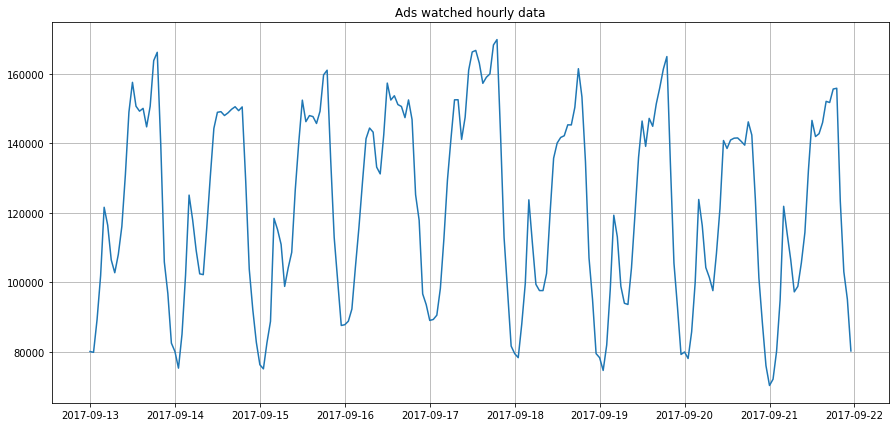

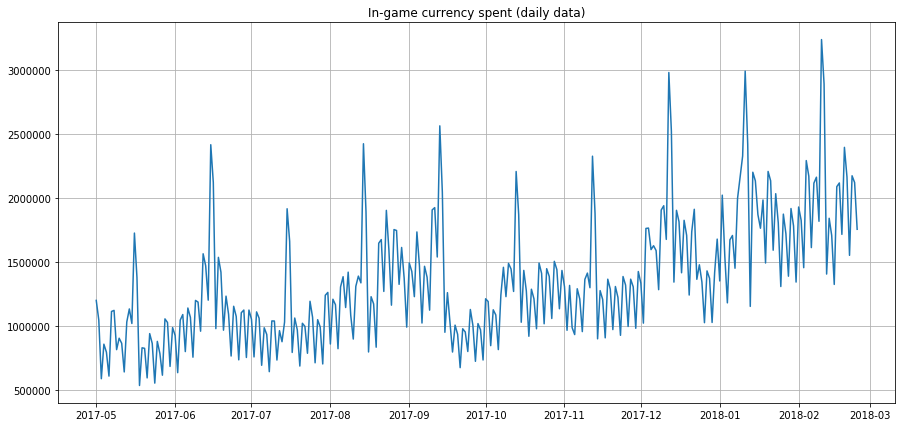

In [9]:
plt.figure(figsize = (15,7))
plt.plot(ads.Ads)
plt.title('Ads watched hourly data')
plt.grid(True)
plt.show()

plt.figure(figsize = (15,7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

In [10]:
moving_average(ads, 24) # prediction for the last observed day (past 24 hours)

116805.0

Unfortunately we cannot use Moving Average, it has another use case- smoothing of the original time series to indicate trends. Pandas has an implementation available.<br>
`DataFrame.rolling(window).mean()`. The wider the window - the smoother wil be the trend. In the case of the very noisy data, which can be very often encountered in finance, this procedure can help to detect common patterns.

In [11]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    '''
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies
    
    '''
    
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(15,5))
    plt.title("Moving Average \n window size ={}".format(window))
    plt.plot(rolling_mean, "g", label = "Rolling Mean Trend")
    
    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns = series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, 'ro', markersize = 10)
            print(series[anomalies.notna().values])
    plt.plot(series[window:], label="Actual Values")
    plt.legend(loc="upper left")
    plt.grid(True)


Why 1.96?
<br>
Hi! The scale actually comes from the underlying assumption of the normality (which, in all honesty, should be tested properly). If we believe our observations are normally distributed, then we say that 95% of our data should lie within 1.96 standard deviations from the mean. Naturally, this number may vary depending on the number of observations you want to cover. Say, you consider an observation to be an outlier if it lies further from the mean by 3 standard deviations, i.e. you cover 99.7% of data with the confidence interval. You may find more info here — https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule

<br>

For 95% the Z value is 1.960

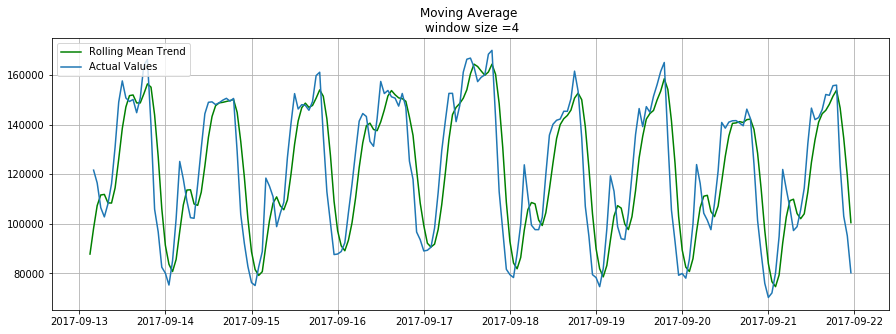

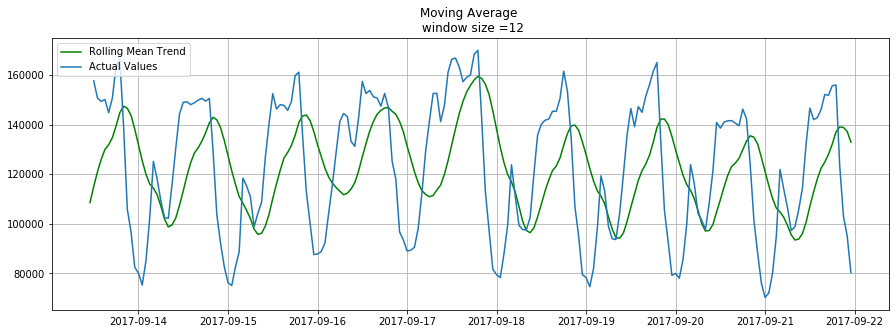

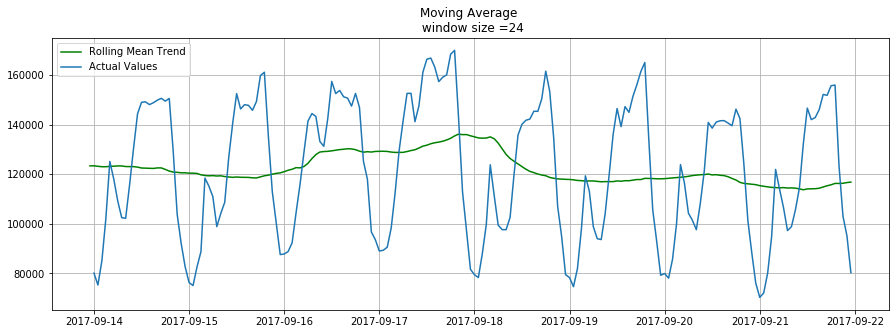

In [12]:
# smoothing by last 4 hours
plotMovingAverage(ads,4)
# smoothing by last 12 hours
plotMovingAverage(ads,12)
# smoothing by 24 hours- we get daily trend
plotMovingAverage(ads,24)

As you can see, applying daily smoothing on hour dat allowed us to clearly see the dynamics of ads watched. During the weekneds the values are higher. 
<br><br>
We can also plot confidence intervals for our smoothed values

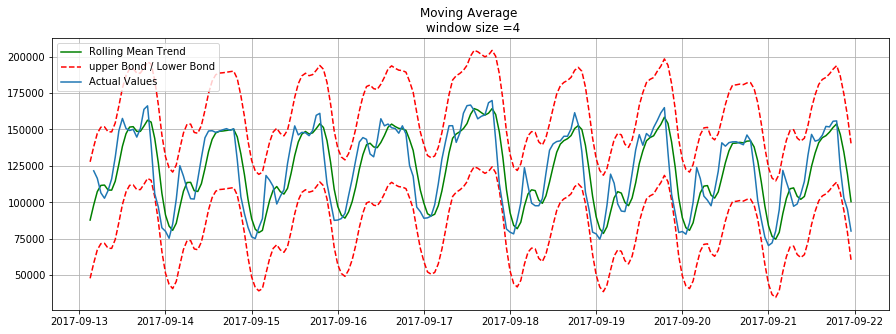

In [13]:
plotMovingAverage(ads, 4, plot_intervals = True)

                         Ads
Time                        
2017-09-21 04:00:00  24382.0


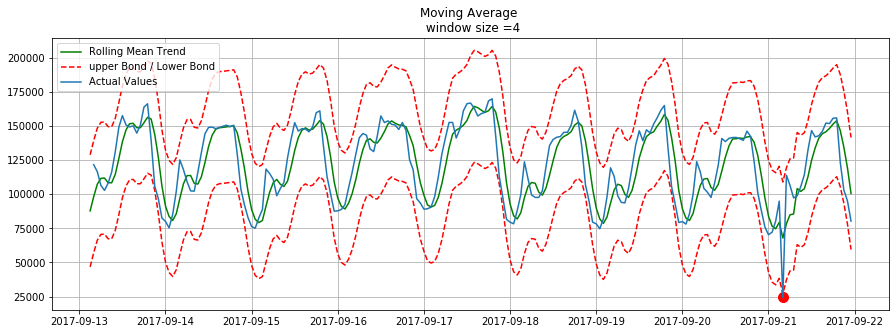

In [14]:
# create a abnormal in the dataframe
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2 # say we have 80% drop of ads

# Lets see if we catch anomaly

plotMovingAverage(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

What about the second series (with weekly smoothing)

            GEMS_GEMS_SPENT
Time                       
2017-06-15          2418723
2017-08-14          2426361
2017-09-13          2566462
2017-11-12          2328862
2017-12-12          2984329
2018-01-11          2995029
2018-01-13          1152460
2018-02-10          3242154


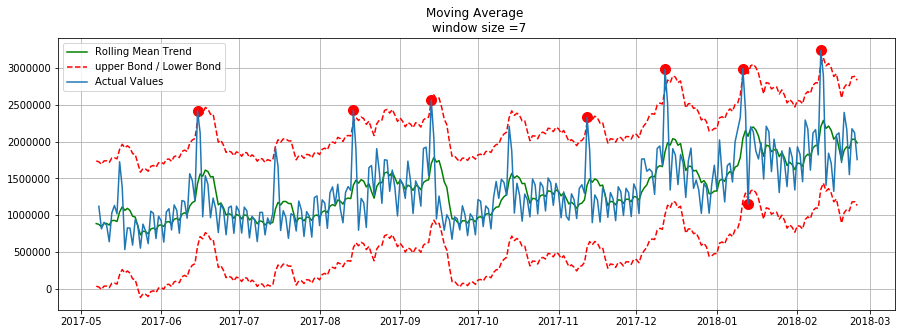

In [15]:
plotMovingAverage(currency, 7, plot_intervals=True, plot_anomalies = True)

**Here is the downside of the simple approach**, it did not catch monthly seasonality in our data and marked almost all 30 days peaks as an anomaly. We do not want to have that many false alarms. Need to consider more complex model

**Weighted average** is a simple modification of the moving average, inside of which observations have different weights summing up to one, usually more recent observations have greater weight.

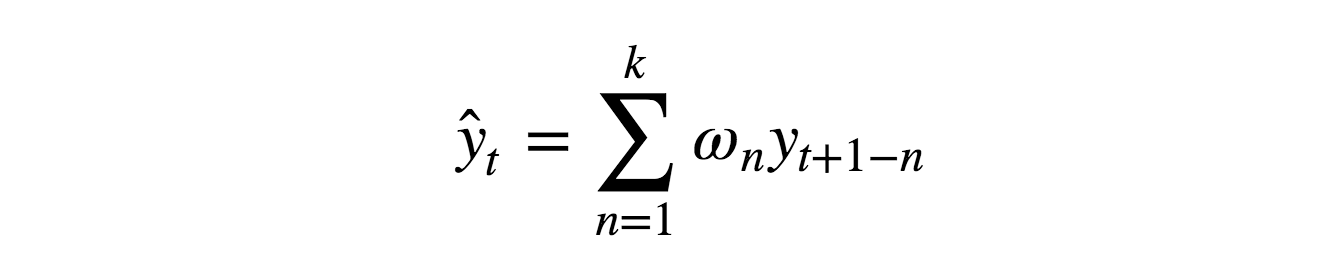

In [16]:
def weighted_average(series, weights):
    """
        Calculate weighter average on series
        weight: List of weight ratio
    """
    result = 0.0
    weights.reverse()                  # reverses the list,inplace=True 
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)
  
weighted_average(ads, [0.6, 0.3, 0.1])

98423.0

#### Exponential Smoothing
Let's take a look at what happens if instead of weighting the last n values of the time series we start weighting all avilable observations while exponentially decreasing weights as we move further back in historical data. The formula of simple exponential smoothing will help.
<br>
alpha is a smoothing factor, defines how quickly we will "forget" the last available true observation. 

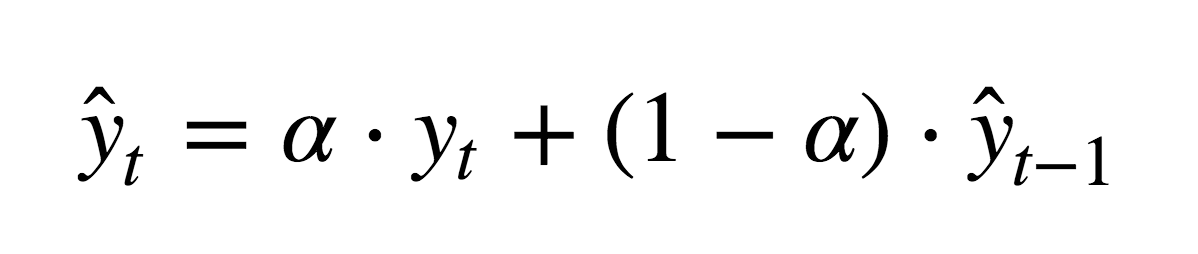

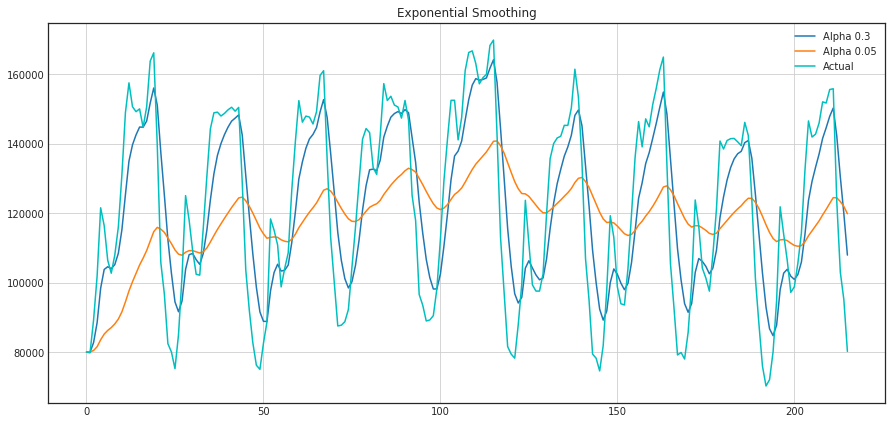

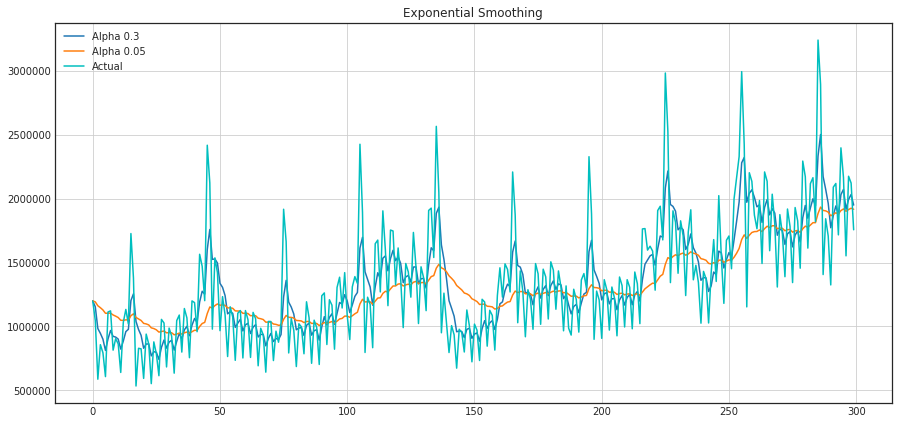

In [17]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series.tolist()[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series.tolist()[n] + (1 - alpha) * result[n-1])
    return result
    
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);
        
plotExponentialSmoothing(ads.Ads, [0.3, 0.05])
plotExponentialSmoothing(currency.GEMS_GEMS_SPENT, [0.3, 0.05])

#### Double Exponential Smoothing
A single future point prediction is not enough, so let's extend exponential smoothing so we can predict two future points.
<br>
Series decomposition should help us- obtain two components: intercept (also level) l and trend (also slope) b. We learn to predict intercept (or expected series value) using previous methods. We apply the same exponential smoothing to the trend, believing naively

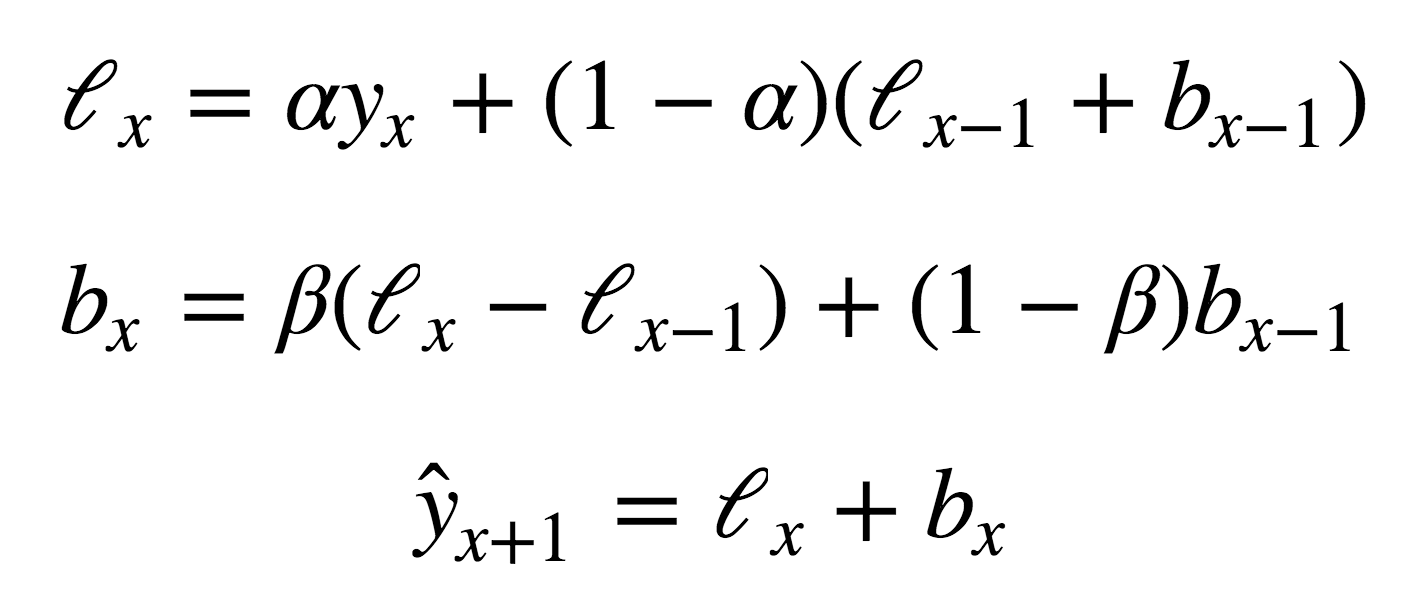

As a result we get a set of functions. The first one describes intercept, as before it depends on the current value of the series, and the second term is now split into previous values of the level and of the trend. The second function describes trend — it depends on the level changes at the current step and on the previous value of the trend. In this case β coefficient is a weight in the exponential smoothing. The final prediction is the sum of the model values of the intercept and trend.

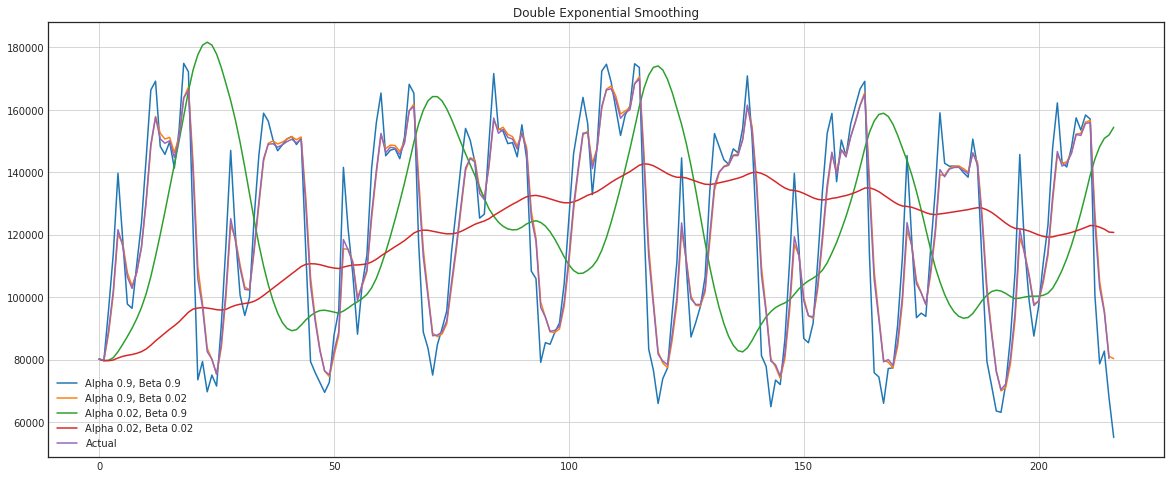

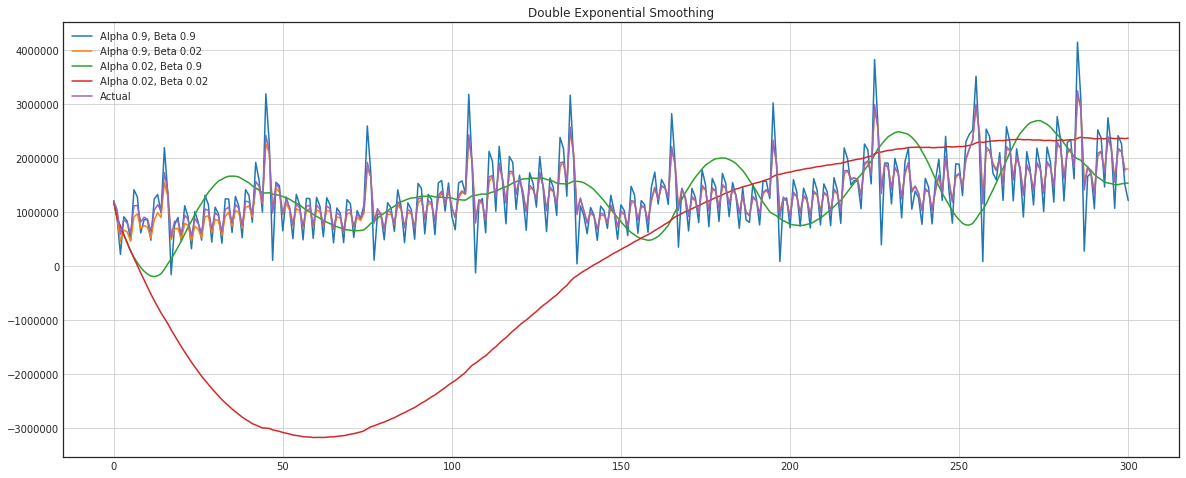

In [18]:
def double_exponential_smoothing(series, alpha, beta):
    '''
        series - dataset with timeseries
        alpha - float [0.0 , 1.0], soothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    '''
    
    # first value is same as series
    result = [series.tolist()[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series.tolist()[0], series.tolist()[1] - series.tolist()[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series.tolist()[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    '''
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    '''
    
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(20,8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label = 'Alpha {}, Beta {}'.format(alpha,beta))
        plt.plot(series.values, label = 'Actual')
        plt.legend(loc='best')
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)
        
plotDoubleExponentialSmoothing(ads.Ads, alphas = [0.9, 0.02], betas=[0.9,0.02])
plotDoubleExponentialSmoothing(currency.GEMS_GEMS_SPENT, alphas = [0.9, 0.02], betas=[0.9,0.02])

Alpha and Beta, bigger the values, the more weight the latest observations will have and the less smoothed the model series will be.

#### Triple Exponential Smoothing a.k.a Holt-Winters
The idea of this method is that we add another, third component **seasonality**. This means we shouldn't use the method if our time series do not have seasonality, which is not the case in our example. Seasonal components in the model will explain repeated variation around intercept and trend, and it will be described by the length of the season, in other words by the period after which variations repeat. For each observation in the season there's seperate component, for example, if the length of the season is 7 (weekly seasonality), we will have 7 seasonal components, one for each day of the week.

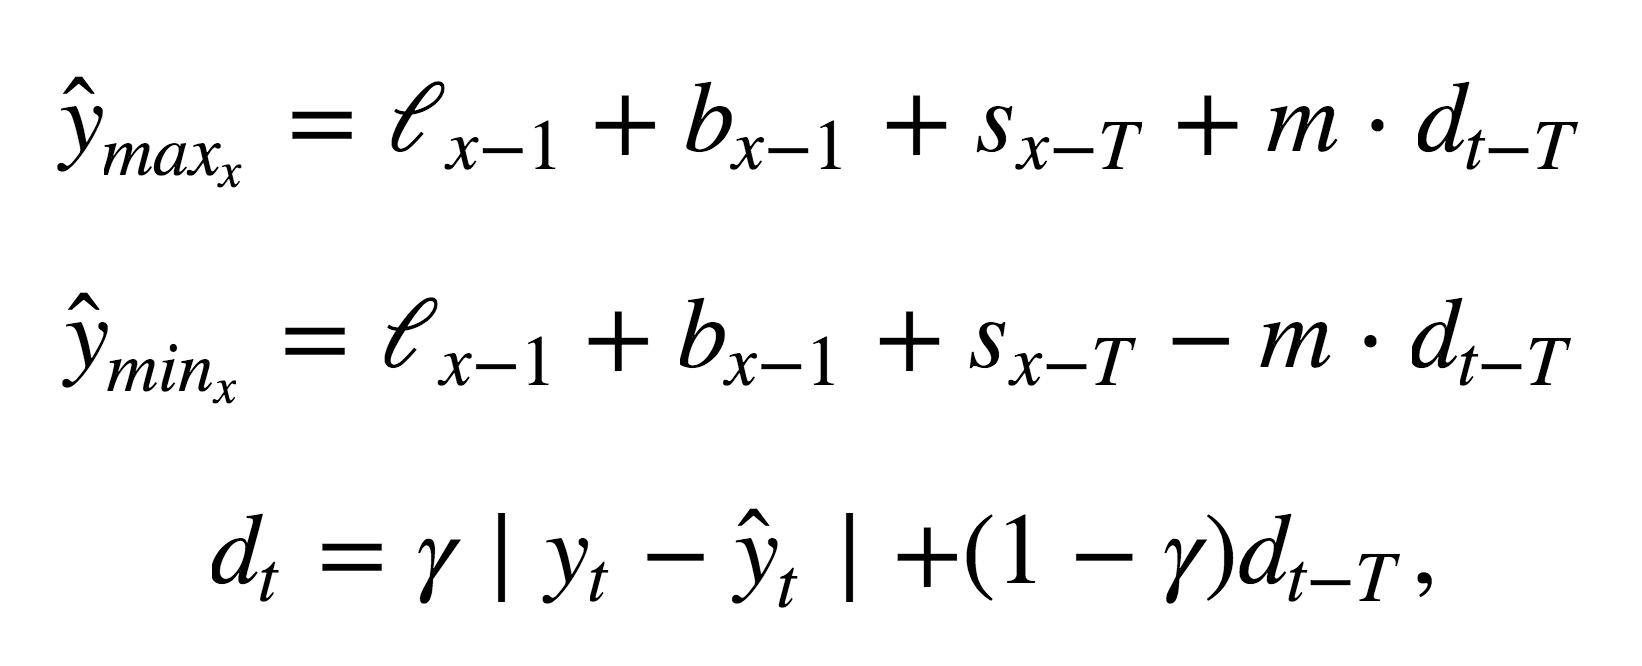

Intercept now depends on the current value of the series minus corresponding seasonal component, trend stays unchanged, and the seasonal component depends on the current value of the series minus intercept and on the previous value of the component. Please take into account that the component is smoothed through all the available seasons, for example, if we have a Monday component then it will only be averaged with other Mondays. You can read more on how averaging works and how initial approximation of the trend and seasonal components is done here. Now that we have seasonal component we can predict not one and not even two but arbitrary mm future steps which is very encouraging.
Below is the code for a triple exponential smoothing model, also known by the last names of its creators — Charles Holt and his student Peter Winters. Additionally Brutlag method was included into the model to build confidence intervals:

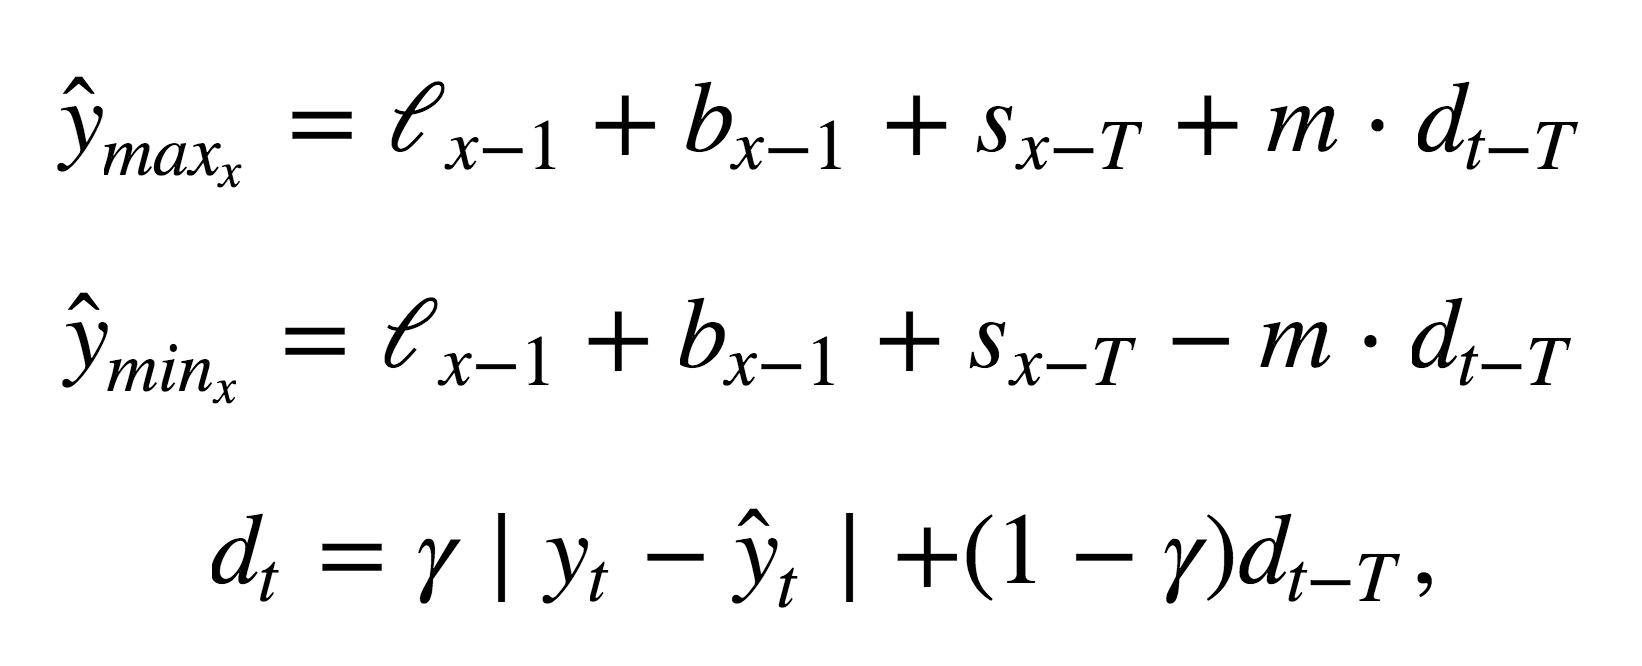

where T is the length of the season, d is the predicted deviation, and the other parameters were taken from the triple exponential smoothing. You can read more about the method and its applicability to anomalies detection in time series here.

In [19]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

## Time series cross validation
Before we start building model let’s talk first about how to estimate model parameters automatically. <br><br>
There’s nothing unusual here, as always we have to choose a loss function suitable for the task, that will tell us how close the model approximates data. Then using cross-validation we will evaluate our chosen loss function for given model parameters, calculate gradient, adjust model parameters and so forth, bravely descending to the global minimum of error. <br><br>
The question is how to do cross-validation on time series, because, you know, **time series do have time structure and one just can’t randomly mix values in a fold without preserving this structure, otherwise all time dependencies between observations will be lost.** That’s why we will have to use a bit more tricky approach to optimization of the model parameters, I don’t know if there’s an official name to it but on CrossValidated, where one can find all the answers but the Answer to the Ultimate Question of Life, the Universe, and Everything, “cross-validation on a rolling basis” was proposed as a name.<br><br>

The idea is rather simple — we train our model on a small segment of the time series, from the beginning until some t, make predictions for the next t+n steps and calculate an error. Then we expand our training sample until t+n value and make predictions from t+n until t+2∗n, and we continue moving our test segment of the time series until we hit the last available observation. As a result we have as many folds as many n will fit between the initial training sample and the last observation.

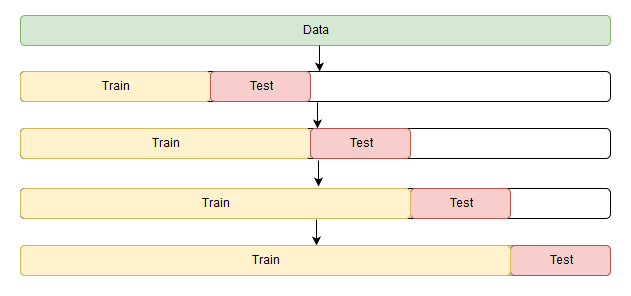

Now, knowing how to set cross-validation, we will find optimal parameters for the Holt-Winters model, recall that we have daily seasonality in ads, hence the `slen=24` parameter


In [20]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In the Holt-Winters model, as well as in the other models of exponential smoothing, there’s a constraint on how big smoothing parameters could be, each of them is in the range from 0 to 1, therefore to minimize loss function we have to choose an algorithm that supports constraints on model parameters, in our case — Truncated Newton conjugate gradient.

In [21]:
%%time
data = ads.Ads[:-20] # leave some data for testing

# initializing model parameters alpha, beta, and gamma
x = [0,0,0]

# minimizing the loss function
opt = minimize(timeseriesCVscore, x0=x,
              args=(data, mean_squared_log_error),
              method = "TNC", bounds = ((0,1),(0,1),(0,1))
              )
# take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting the next 50 hours
model = HoltWinters(data, slen = 24,
                   alpha = alpha_final,
                   beta= beta_final,
                   gamma = gamma_final,
                   n_preds = 50,
                   scaling_factor = 3)

model.triple_exponential_smoothing()

0.11652680227350454 0.002677697431105852 0.05820973606789237
Wall time: 2.89 s


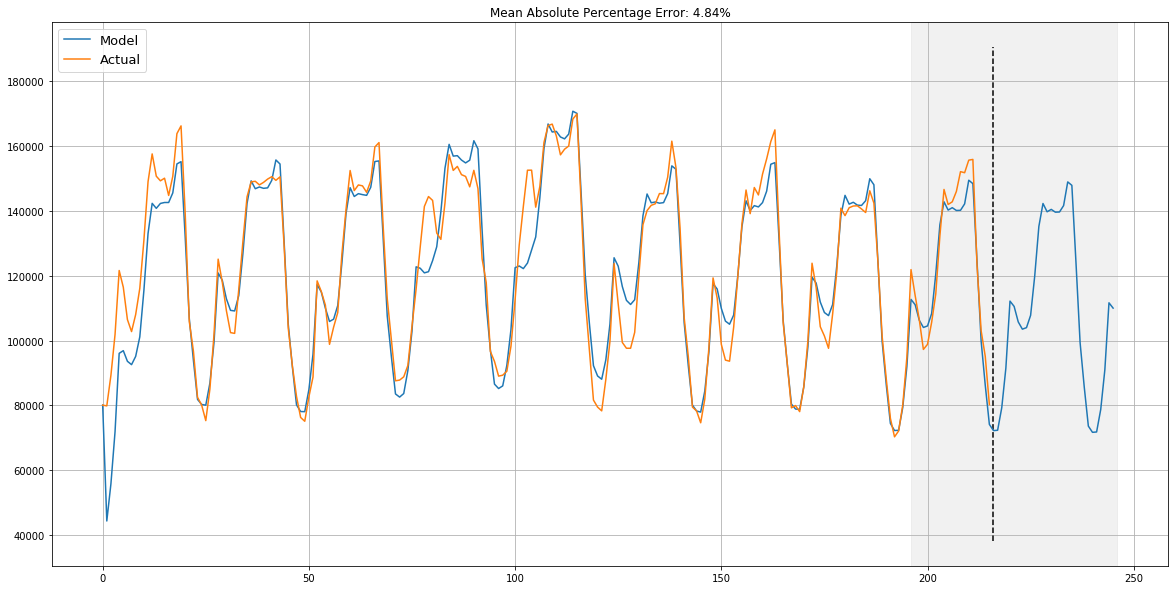

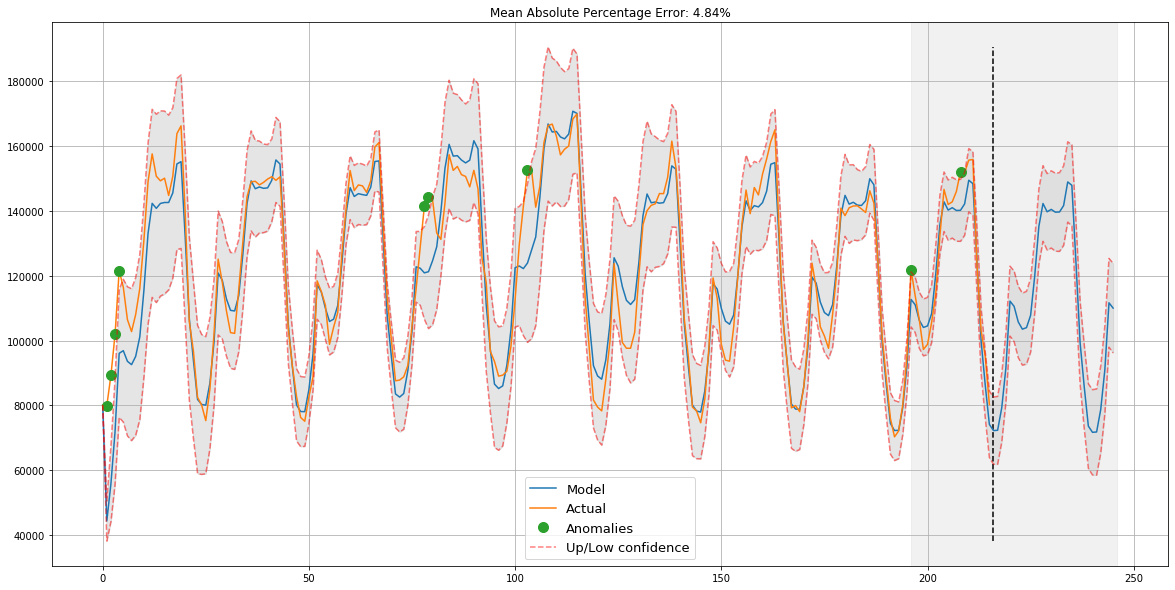

In [22]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);
    
plotHoltWinters(ads.Ads)
plotHoltWinters(ads.Ads, plot_intervals=True, plot_anomalies=True)

Judging by the chart, our model was able to successfully approximate the initial time series, catching daily seasonality, overall downwards trend and even some anomalies.

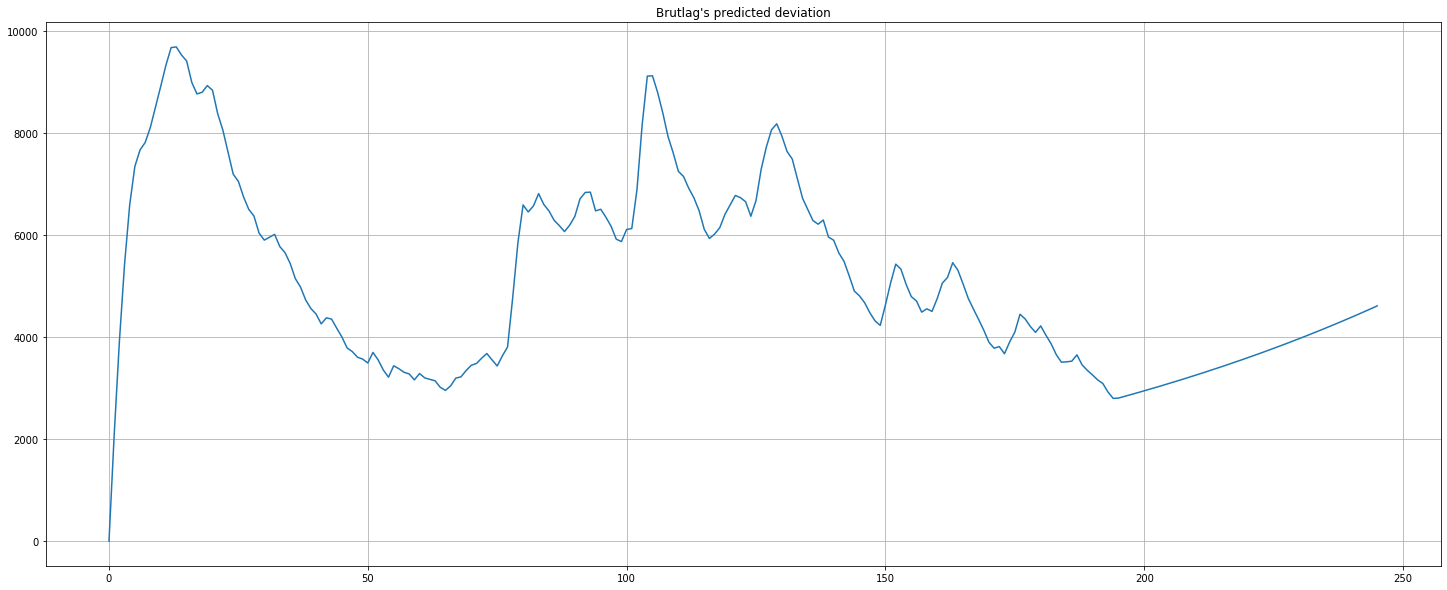

In [23]:
plt.figure(figsize=(25, 10))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

 If you take a look at the modeled deviation, you can clearly see that the model reacts quite sharply to the changes in the structure of the series but then quickly returns deviation to the normal values, "forgetting" the past. This feature of the model allows us to quickly build anomaly detection systems even for quite noisy series without spending too much time and money on preparing data and trainng the model.

We’ll apply the same algorithm for the second series which, as we know, has trend and 30-day seasonality

In [24]:
%%time
data = currency.GEMS_GEMS_SPENT[:-50] 
slen = 30 # 30-day seasonality

x = [0, 0, 0] 

opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_absolute_percentage_error, slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 100, scaling_factor = 3)
model.triple_exponential_smoothing()

0.012841445048055122 0.04883371471892228 0.00943678056045777
Wall time: 5.22 s


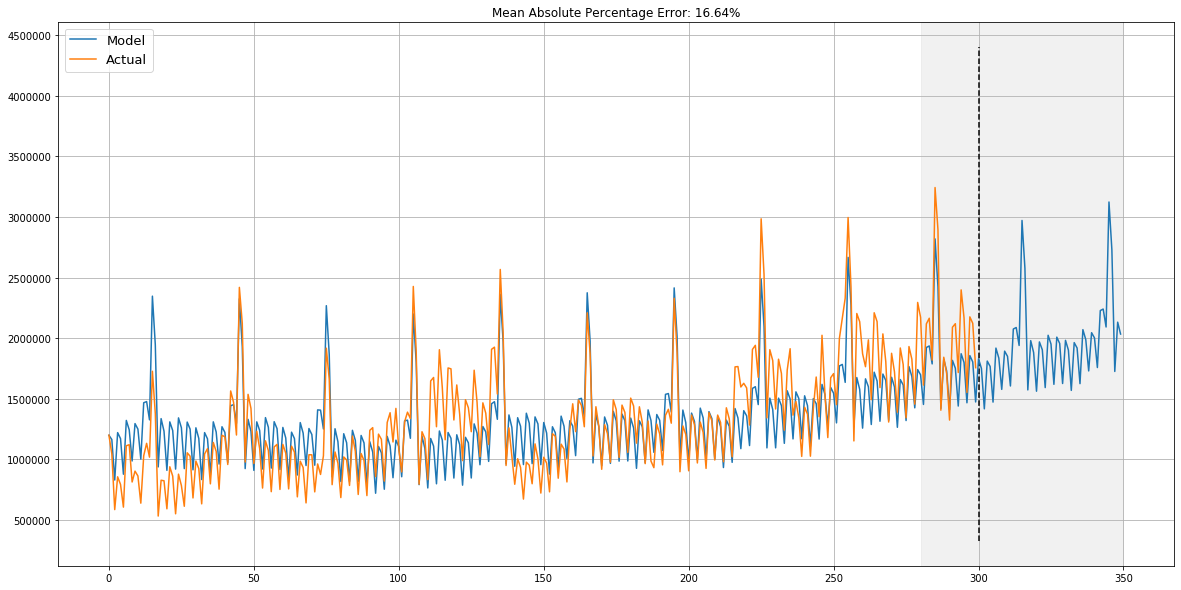

In [25]:
plotHoltWinters(currency.GEMS_GEMS_SPENT)

Looks quite adequate, model has caught both upwards trend and seasonal spikes and overall fits our values nicely


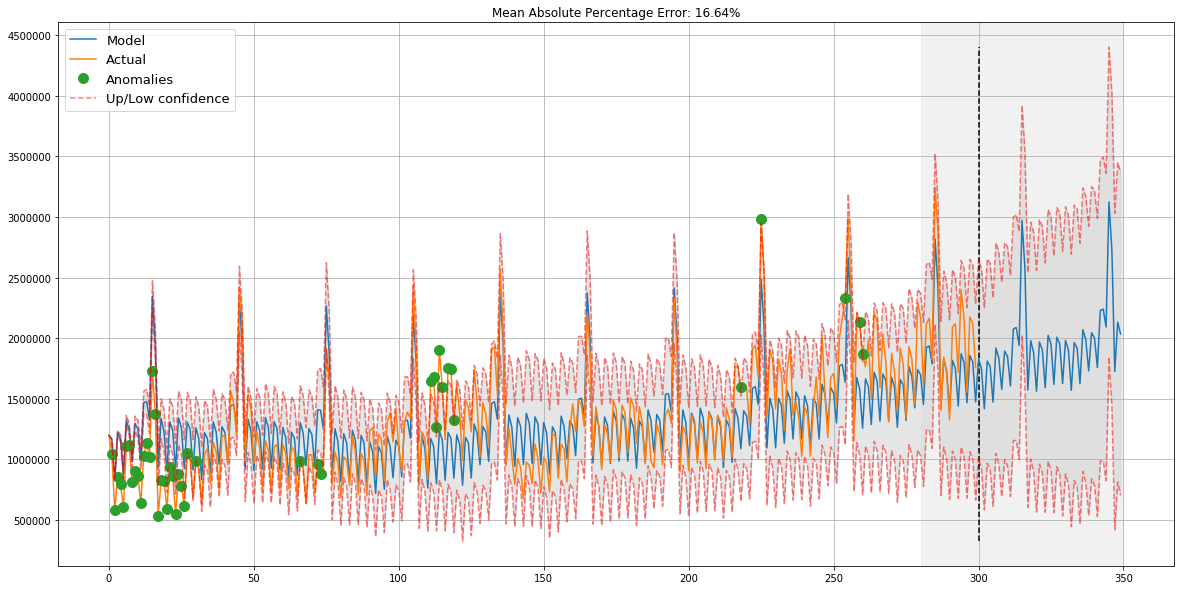

In [26]:
plotHoltWinters(currency.GEMS_GEMS_SPENT, plot_intervals=True, plot_anomalies=True)

Caught some anomalies as well


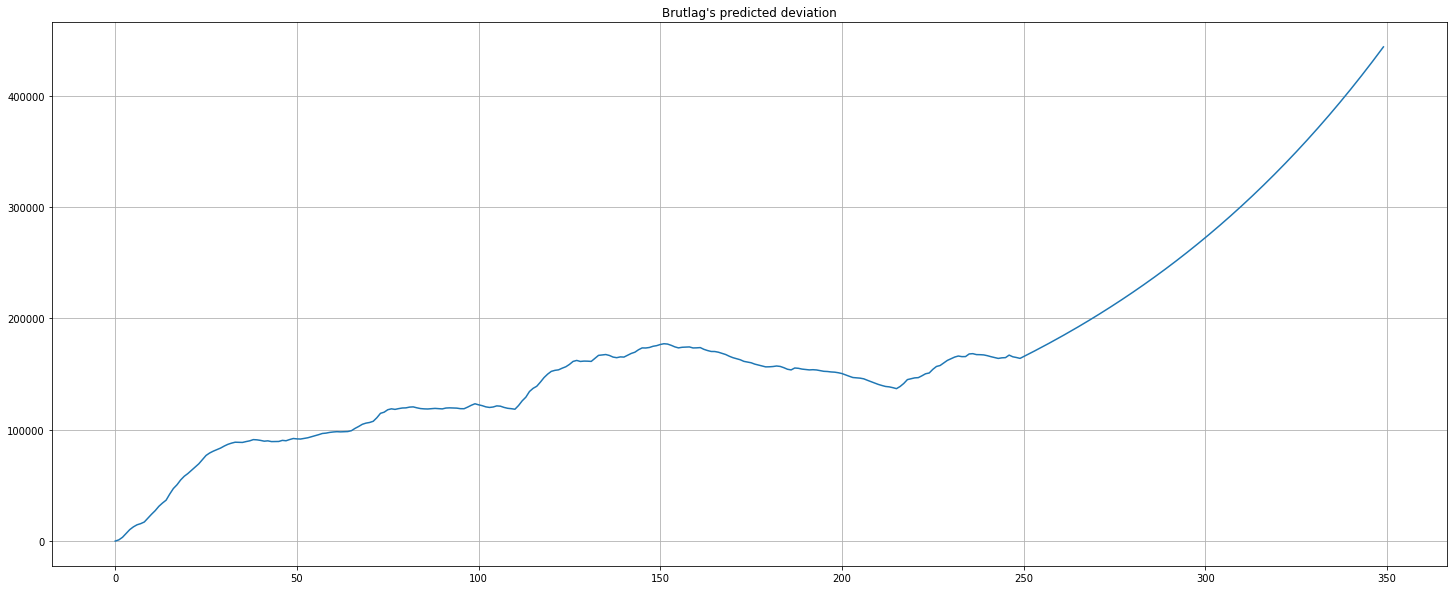

In [27]:
plt.figure(figsize=(25, 10))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

Deviations increases as forecast period moves further

## Econometric Approach

### Stationarity

Before we start modeling we should mention such an important property of time series as ***stationarity***

<br>
If the process is stationary that means it doesn't change its statistical properties over time, namely mean and variance do not change over time (constancy of variance is also called **homoscedasticity**), also covariance function does not depend on the time (should only depend on the distance between observations). You can see this visually on the picture.

- the red graph below is not stationary because the mean increases over time
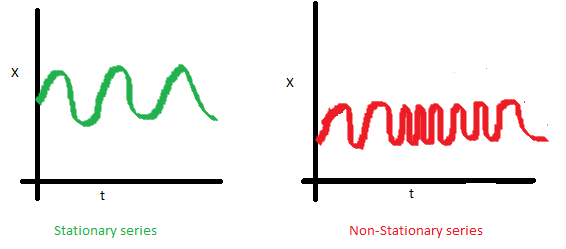
- we were unlucky with the variacne, see the varying spread of values over time.
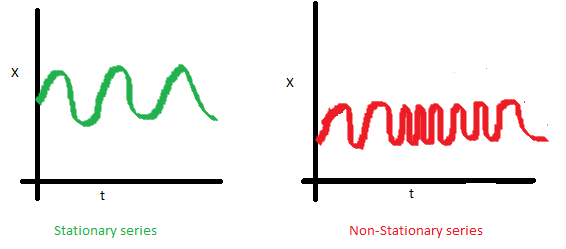
- Finally, the covariance of the i th term and the (i + m) th term should not be a function of time. In the following graph, you will notice the spread becomes closer as the time increases. Hence, the covariance is not constant with time for the right chart.
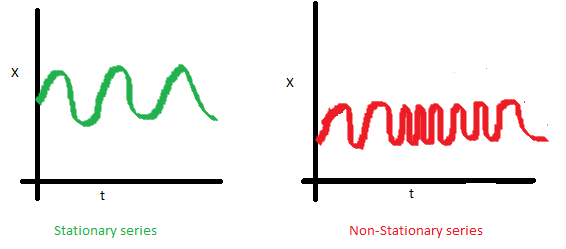


So why stationarity is so important? **Because it is easy to make predictions on the statinoary series as we assume that the future statistical properties will not be different from the currently observed.** Most of the time series models in one way or the other model and predict those properties (mean or variance, for example), that's why predictions would be wrong if the original series were not stationary. Unfortunately most of the time series we see outside of textbooks are non-stationary but we can (and should) change this.

So, to fight non-stationarity we have to know our enemy so to say. Let’s see **how to detect it**. To do that we will now take a look at the white noise and random walks and we will learn how to get from one to another for free, without registration and SMS.

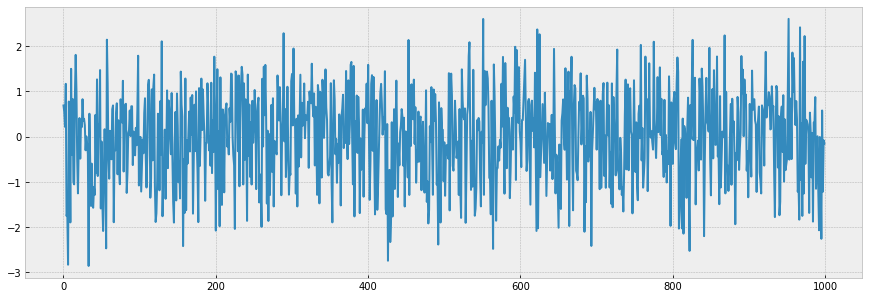

In [28]:
# White noise chart:

white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

So the process generated by standard normal distribution is stationary and oscillates around 0 with with deviation of 1. Now based on this process we will generate a new one where each next value will depend on the previous one: x(t)=ρ*x(t−1)+e(t)

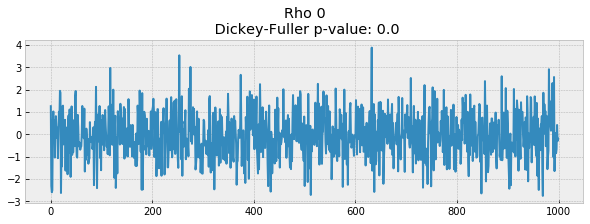

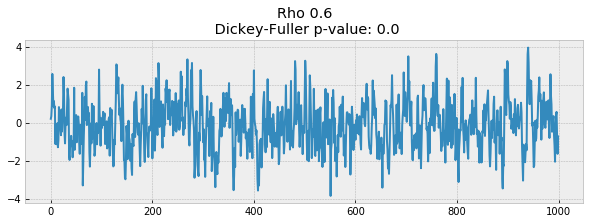

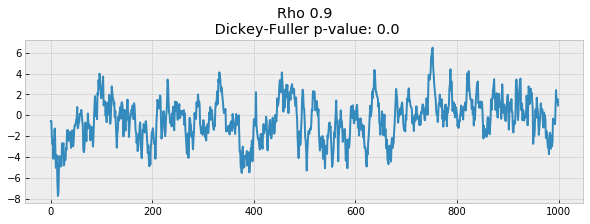

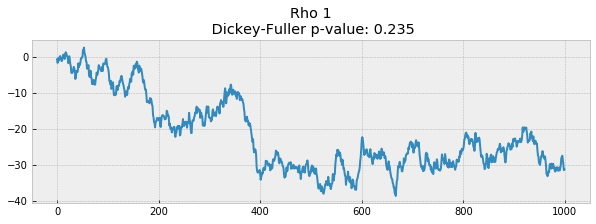

In [29]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

On the first chart you can see the same stationary white noise you’ve seen before. On the second one the value of ρρ increased to 0.6, as a result wider cycles appeared on the chart but overall it is still stationary. The third chart deviates even more from the 0 mean but still oscillates around it. Finally, the value of ρ equal to 1 gives us a random walk process — non-stationary time series.

This happens because after reaching the critical value the series x(t)=ρ*x(t−1)+e(t) does not return to its mean value. If we subtract x(t−1) from the left and the right side we will get x(t)−x(t−1)=(ρ−1)*x(t−1)+e(t), where the expression on the left is called the first difference. If ρ=1 then the first difference gives us stationary white noise e(t). This fact is the main idea of the Dickey-Fuller test for the stationarity of time series (presence of a unit root). If we can get stationary series from non-stationary using the first difference we call those series integrated of order 1. Null hypothesis of the test — time series is non-stationary, was rejected on the first three charts and was accepted on the last one. We’ve got to say that the first difference is not always enough to get stationary series as the process might be integrated of order d, d > 1 (and have multiple unit roots), in such cases the augmented Dickey-Fuller test is used that checks multiple lags at once.

<br>
We can fight non-stationarity using different approaches — various order differences, trend and seasonality removal, smoothing, also using transformations like Box-Cox or logarithmic.

## Getting rid of non-stationarity and building SARIMA

Now let’s build an ARIMA model by walking through all the circles of hell stages of making series stationary.

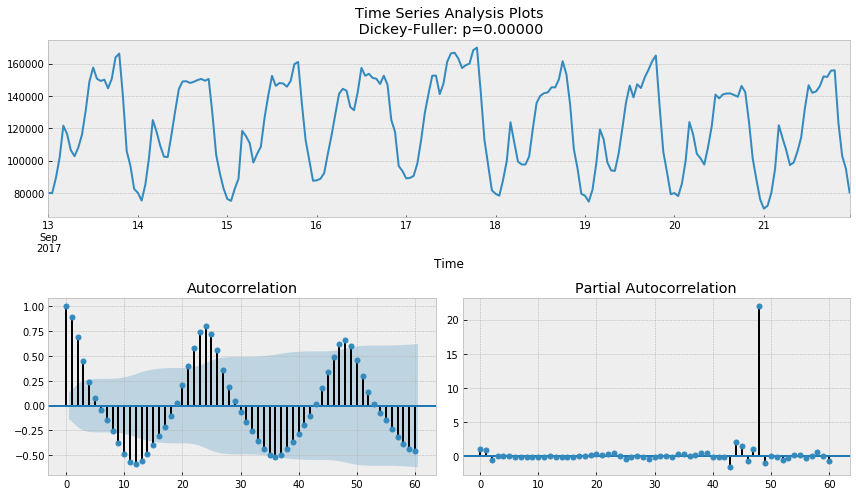

In [30]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(ads.Ads, lags=60)

Surprisingly, initial series are stationary, Dickey-Fuller test rejected null hypothesis that a unit root is present. Actually, it can be seen on the plot itself — we don’t have a visible trend, so mean is constant, variance is pretty much stable throughout the series.<br>
The only thing left is seasonality which we have to deal with before modelling. To do so let’s take “seasonal difference” which means a simple subtraction of series from itself with a lag that equals the seasonal period.

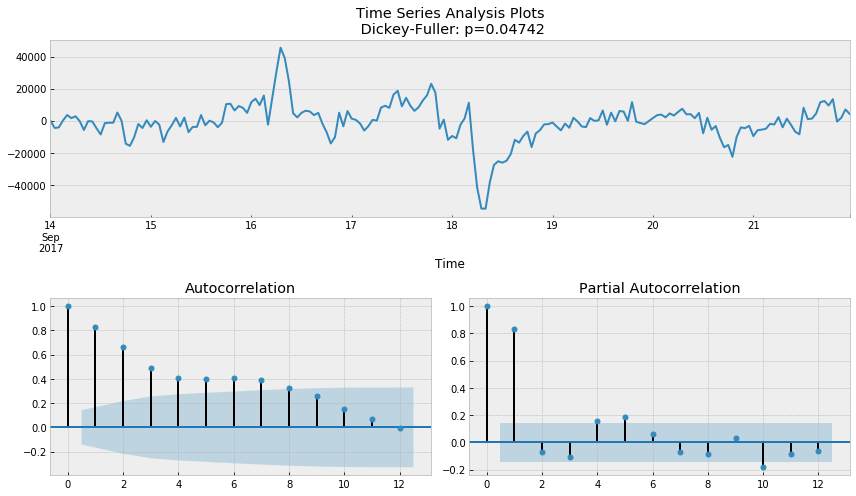

In [34]:
ads_diff = ads.Ads - ads.Ads.shift(24)
tsplot(ads_diff[24:], lags=60)

That’s better, visible seasonality is gone, however autocorrelation function still has too many significant lags. To remove them we’ll take first differences — subtraction of series from itself with lag 1

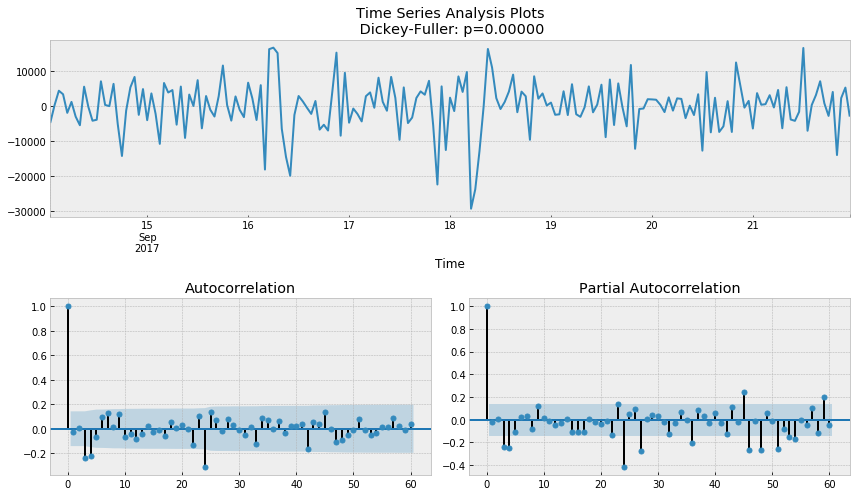

In [32]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

Perfect! Our series now look like something undescribable, oscillating around zero, Dickey-Fuller indicates that it’s stationary and the number of significant peaks in ACF has dropped. We can finally start modelling!

In [33]:
ads

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630
2017-09-13 05:00:00,116475
2017-09-13 06:00:00,106495
2017-09-13 07:00:00,102795
2017-09-13 08:00:00,108055


## top 5

In [ ]:
idf = pd.read_csv('./Data/inventory_split.csv')

In [300]:
import datetime as dt
idf['Document date'] = pd.to_datetime(idf['Document date'])
idf['cw-'] = (idf['Document date'] - pd.to_datetime('today')).apply(lambda x: x.days)//7

In [303]:
top5_ = idf.pivot_table(values ='Order qty', index = ['Description'],aggfunc = lambda x: x.sum()).sort_values(by = 'Order qty', ascending = False).index[:5]
temp = pd.DataFrame(idf[idf['Description'].isin([top5_[0]])].pivot_table(values='Order qty', index = ['cw-'], columns = 'Plant',aggfunc = lambda x: x.sum()).fillna(0)['USJ7'])

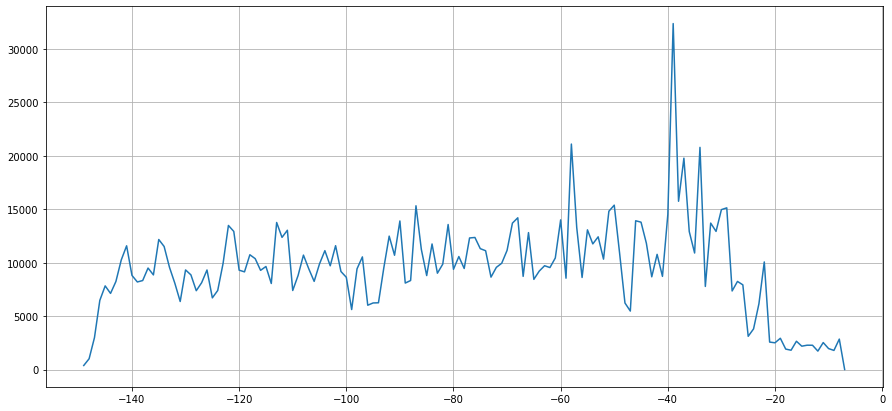

        USJ7
cw-         
-58  21086.0
-39  32353.0
-36  12902.0


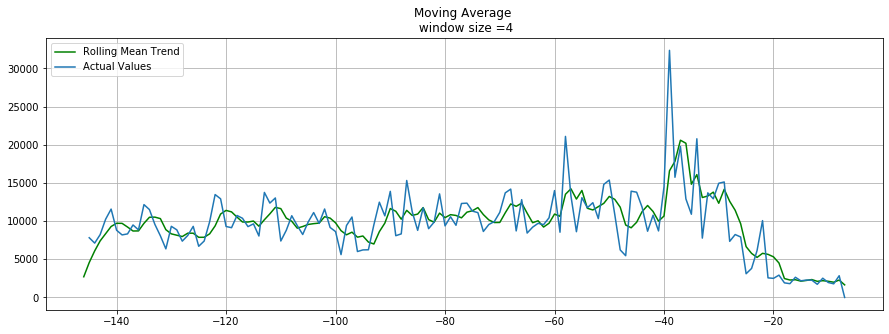

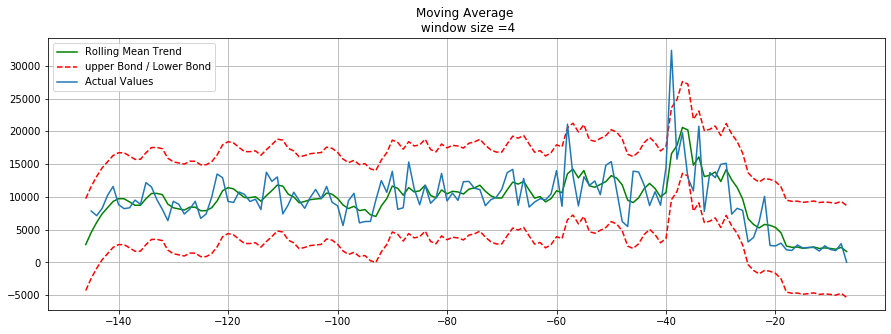

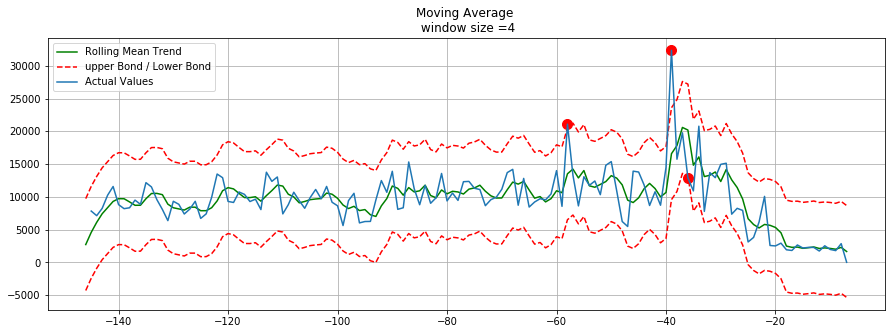

In [326]:
plt.figure(figsize = (15,7))
plt.plot(temp)
plt.grid(True)
plt.show()

plotMovingAverage(temp,4) # per Month
plotMovingAverage(temp, 4, plot_intervals = True)
plotMovingAverage(temp, 4, plot_intervals=True, plot_anomalies = True)


In [330]:
idf[idf['cw-'].isin([-58,-39,-36])]['Document date'].unique()

array(['2018-09-12T00:00:00.000000000', '2018-09-10T00:00:00.000000000',
       '2018-09-07T00:00:00.000000000', '2018-09-11T00:00:00.000000000',
       '2018-09-06T00:00:00.000000000', '2018-09-09T00:00:00.000000000',
       '2019-01-23T00:00:00.000000000', '2019-01-21T00:00:00.000000000',
       '2019-01-19T00:00:00.000000000', '2019-01-17T00:00:00.000000000',
       '2019-01-22T00:00:00.000000000', '2019-01-18T00:00:00.000000000',
       '2019-02-11T00:00:00.000000000', '2019-02-13T00:00:00.000000000',
       '2019-02-08T00:00:00.000000000', '2019-02-07T00:00:00.000000000',
       '2019-02-12T00:00:00.000000000', '2019-02-10T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [374]:
ads.Ads

Time
2017-09-13 00:00:00     80115
2017-09-13 01:00:00     79885
2017-09-13 02:00:00     89325
2017-09-13 03:00:00    101930
2017-09-13 04:00:00    121630
2017-09-13 05:00:00    116475
2017-09-13 06:00:00    106495
2017-09-13 07:00:00    102795
2017-09-13 08:00:00    108055
2017-09-13 09:00:00    116125
2017-09-13 10:00:00    131030
2017-09-13 11:00:00    149020
2017-09-13 12:00:00    157590
2017-09-13 13:00:00    150715
2017-09-13 14:00:00    149295
2017-09-13 15:00:00    150100
2017-09-13 16:00:00    144780
2017-09-13 17:00:00    150690
2017-09-13 18:00:00    163840
2017-09-13 19:00:00    166235
2017-09-13 20:00:00    139520
2017-09-13 21:00:00    105895
2017-09-13 22:00:00     96780
2017-09-13 23:00:00     82520
2017-09-14 00:00:00     80125
2017-09-14 01:00:00     75335
2017-09-14 02:00:00     85105
2017-09-14 03:00:00    102080
2017-09-14 04:00:00    125135
2017-09-14 05:00:00    118030
                        ...  
2017-09-20 18:00:00    146215
2017-09-20 19:00:00    142425
2017-

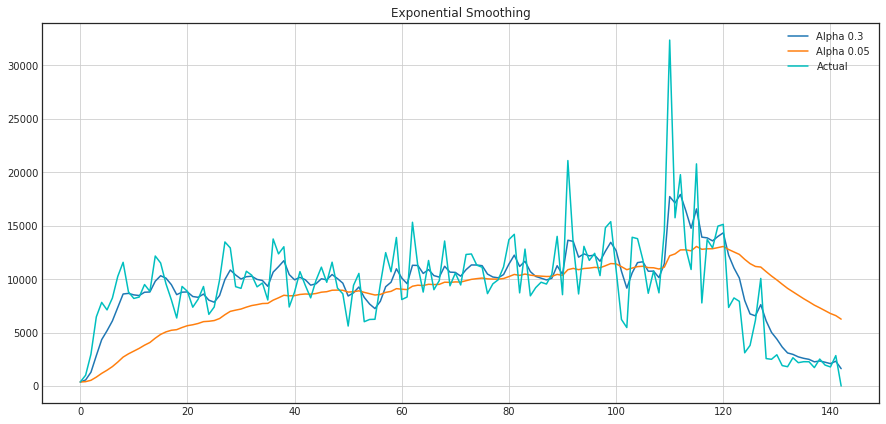

In [385]:
plotExponentialSmoothing(temp['USJ7'], [0.3,0.05])

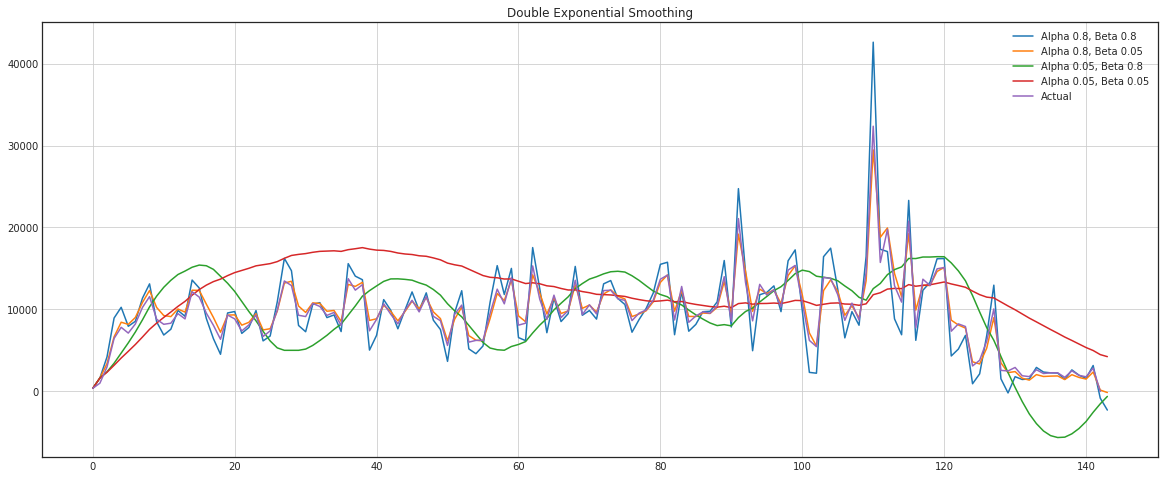

In [389]:
plotDoubleExponentialSmoothing(temp['USJ7'], alphas = [0.8, 0.05], betas=[0.8,0.05])